# custom instance segmentation by rtdetr、sam、text.

## base config

In [2]:
from ppdet.utils.cli import merge_args
from argparse import ArgumentParser, RawDescriptionHelpFormatter

class ArgsParser(ArgumentParser):
    def __init__(self):
        super(ArgsParser, self).__init__(
            formatter_class=RawDescriptionHelpFormatter)
#         self.add_argument("-c", "--config", help="configuration file to use")
#         self.add_argument(
#             "-o", "--opt", nargs='*', help="set configuration options")

    def parse_args(self, argv=None):
        args = super(ArgsParser, self).parse_args(argv)
        assert args.config is not None, \
            "Please specify --config=configure_file_path."
        args.opt = self._parse_opt(args.opt)
        return args

    def _parse_opt(self, opts):
        config = {}
        if not opts:
            return config
        for s in opts:
            s = s.strip()
            k, v = s.split('=', 1)
            if '.' not in k:
                config[k] = yaml.load(v, Loader=yaml.Loader)
            else:
                keys = k.split('.')
                if keys[0] not in config:
                    config[keys[0]] = {}
                cur = config[keys[0]]
                for idx, key in enumerate(keys[1:]):
                    if idx == len(keys) - 2:
                        cur[key] = yaml.load(v, Loader=yaml.Loader)
                    else:
                        cur[key] = {}
                        cur = cur[key]
        return config


def parse_args():
    parser = ArgsParser()
    parser.add_argument(
        "--config",
        type=str,
        default="RTDETR/configs/detr/detr_r50_1x_coco.yml",
        help="configuration file to use")
    parser.add_argument(
        "--opt",
        type=str,
        default=None,
        help="set configuration options")
    parser.add_argument(
        "--infer_dir",
        type=str,
        default=None,
        help="Directory for images to perform inference on.")
    parser.add_argument(
        "--infer_img",
        type=str,
        default=None,
        help="Image path, has higher priority over --infer_dir")
    parser.add_argument(
        "--output_dir",
        type=str,
        default="output",
        help="Directory for storing the output visualization files.")
    parser.add_argument(
        "--draw_threshold",
        type=float,
        default=0.5,
        help="Threshold to reserve the result for visualization.")
    parser.add_argument(
        "--slim_config",
        default=None,
        type=str,
        help="Configuration file of slim method.")
    parser.add_argument(
        "--use_vdl",
        type=bool,
        default=False,
        help="Whether to record the data to VisualDL.")
    parser.add_argument(
        '--vdl_log_dir',
        type=str,
        default="vdl_log_dir/image",
        help='VisualDL logging directory for image.')
    parser.add_argument(
        "--save_results",
        type=bool,
        default=False,
        help="Whether to save inference results to output_dir.")
    parser.add_argument(
        "--slice_infer",
        action='store_true',
        help="Whether to slice the image and merge the inference results for small object detection."
    )
    parser.add_argument(
        '--slice_size',
        nargs='+',
        type=int,
        default=[640, 640],
        help="Height of the sliced image.")
    parser.add_argument(
        "--overlap_ratio",
        nargs='+',
        type=float,
        default=[0.25, 0.25],
        help="Overlap height ratio of the sliced image.")
    parser.add_argument(
        "--combine_method",
        type=str,
        default='nms',
        help="Combine method of the sliced images' detection results, choose in ['nms', 'nmm', 'concat']."
    )
    parser.add_argument(
        "--match_threshold",
        type=float,
        default=0.6,
        help="Combine method matching threshold.")
    parser.add_argument(
        "--match_metric",
        type=str,
        default='ios',
        help="Combine method matching metric, choose in ['iou', 'ios'].")
    parser.add_argument(
        "--visualize",
        type=ast.literal_eval,
        default=True,
        help="Whether to save visualize results to output_dir.")
    args = parser.parse_args()
    return args

def load_config(file_path):
    _, ext = os.path.splitext(file_path)
    assert ext in ['.yml', '.yaml'], "only support yaml files for now"

    # load config from file and merge into global config
    cfg = _load_config_with_base(file_path)
    cfg['filename'] = os.path.splitext(os.path.split(file_path)[-1])[0]
    merge_config(cfg)
    return global_config



ModuleNotFoundError: No module named 'ppdet'

In [8]:
import paddle
import sys
sys.path.insert(0,"RTDETR/")
from ppdet.core.workspace import load_config, merge_config
from ppdet.engine import Trainer, Trainer_ARSL
from ppdet.utils.check import check_gpu, check_npu, check_xpu, check_mlu, check_version, check_config
from ppdet.utils.cli import ArgsParser, merge_args
from ppdet.slim import build_slim_model
import warnings
warnings.filterwarnings('ignore')
import glob
import ast

FLAGS = parse_args()
# cfg = load_config("RTDETR/configs/detr/detr_r50_1x_coco.yml")
# merge_args(cfg, FLAGS)
# merge_config(FLAGS.opt)
print(cfg)


usage: ipykernel_launcher.py [-h] [-c CONFIG] [-o [OPT [OPT ...]]]
                             [--infer_dir INFER_DIR] [--infer_img INFER_IMG]
                             [--output_dir OUTPUT_DIR]
                             [--draw_threshold DRAW_THRESHOLD]
                             [--slim_config SLIM_CONFIG] [--use_vdl USE_VDL]
                             [--vdl_log_dir VDL_LOG_DIR]
                             [--save_results SAVE_RESULTS] [--slice_infer]
                             [--slice_size SLICE_SIZE [SLICE_SIZE ...]]
                             [--overlap_ratio OVERLAP_RATIO [OVERLAP_RATIO ...]]
                             [--combine_method COMBINE_METHOD]
                             [--match_threshold MATCH_THRESHOLD]
                             [--match_metric MATCH_METRIC]
                             [--visualize VISUALIZE]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1000/jupyter/kernel-cbc095df-5fe8-4071-a407-381b1000780a.json


SystemExit: 2

In [19]:
#you can use these label to find targets in image.
label_list=['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
class_to_idx = {label_list[i]:i for i in range(len(label_list))}
#you want to find target's label.
find_label=['person','fork']
image_path='images/person.jpg'
infer_device="cuda"


In [80]:
#import all the module of python
from matplotlib import pyplot as plt
import numpy as np

import cv2
from super_gradients.training import models as yolon
from segment_anything import sam_model_registry, SamPredictor
import torch


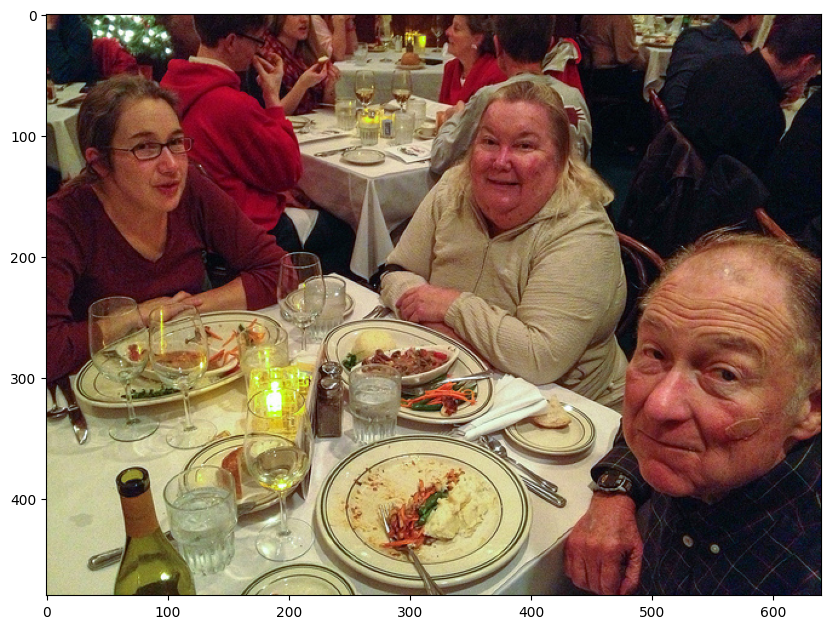

In [3]:
#ready the image to RAM

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [126]:
#define some ultity tools.
def show_max_mask(masks, ax, random_color=False):
    max_mask_index=None
    max_area=0
    for index,mask in enumerate(masks):
        area=np.sum(mask)
        if area>max_area:
            max_area=area
            max_mask_index=index
    if max_mask_index:
        mask=masks[max_mask_index]
    
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  
    
def show_box_and_label(boxes,ax,labels):  
    for index,box in enumerate(boxes):
        x0, y0 = box[0], box[1]
        w, h = box[2] - box[0], box[3] - box[1]
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
        ax.text(x0, y0, labels[index], fontsize=11)
    
    
    

## define config of SAM.

In [114]:
#set up the sam engine
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=infer_device)
sam_engine = SamPredictor(sam)
sam_engine.set_image(image)


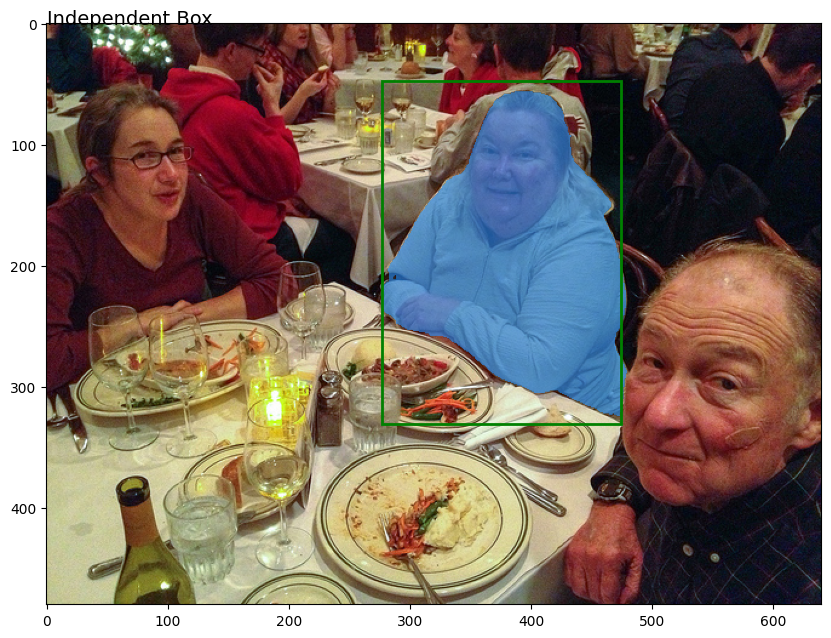

In [115]:
#test the sam engine is ok using simple infer.
input_box = np.array([277, 47, 474, 331])
masks, scores, logits = sam_engine.predict(
    point_coords=None,
    point_labels=None,
    box=input_box,
    multimask_output=True,
)
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_max_mask(masks,plt.gca())
show_box(input_box, plt.gca())

## define config of YOLO-NAS.

In [47]:
##set up the yolo-nas engine
yolon_engine = yolon.get('yolo_nas_l', pretrained_weights='coco') # yolo_nas_l is the yolo_nas large model

[2023-07-07 10:54:42] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


[2023-07-07 11:35:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


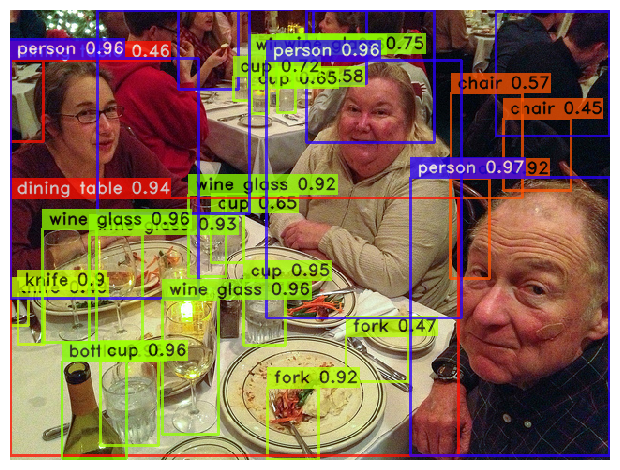

In [102]:
#test the yolo-nas engine is ok using simple infer.
detection_pred=yolon_engine.predict(image, conf=0.45)
detection_pred.show()

## construct the function of instance segmentation.

In [129]:
##postprocess result of predict
input_boxes_list=[]
input_boxes_label_list=[]
predict_labels = detection_pred[0].prediction.labels.tolist()
predict_bboxes_xyxy = detection_pred[0].prediction.bboxes_xyxy.tolist()
predict_labels = detection_pred[0].prediction.labels.tolist()

## get instance segmentation's target labels.
instance_seg_target_labels=[class_to_idx.get(label) for label in find_label]
print(instance_seg_target_labels)
for i,predict_label in enumerate(predict_labels):
    if int(predict_label)in instance_seg_target_labels:
        input_boxes_list.append(predict_bboxes_xyxy[i].copy())
        input_boxes_label_list.append(label_list[int(predict_label)])
print(len(input_boxes_list))

[0, 42]
10


In [130]:
#put the prompt boxes to sam.
input_boxes = torch.tensor(input_boxes_list, device=infer_device)
transformed_boxes = sam_engine.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = sam_engine.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)


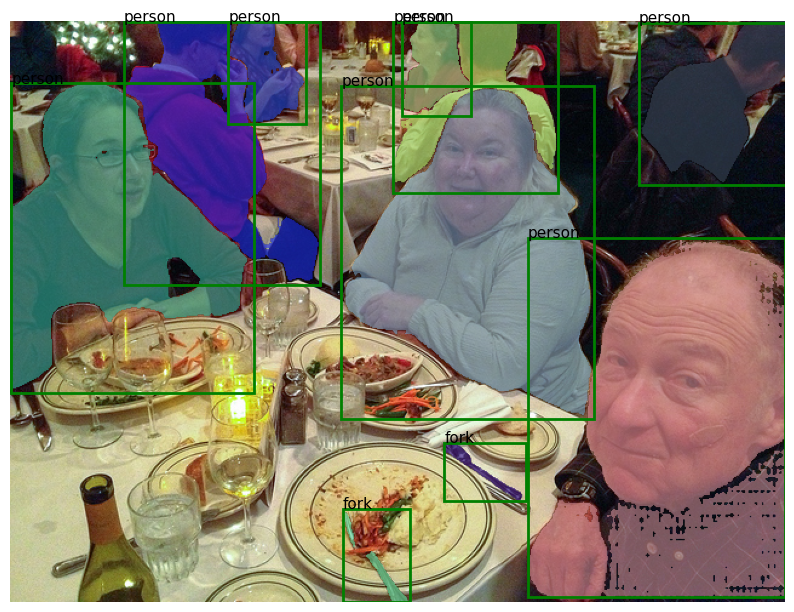

In [131]:
#draw the messages.
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
show_box_and_label(input_boxes_list,plt.gca(),input_boxes_label_list)
plt.axis('off')
plt.show()